Elaluation of the model on the other dasets:

1. MICCAI 2019 dataset

# MICCAI 2019


Dataset: [link](https://www.kaggle.com/datasets/xiaoweixumedicalai/chd68-segmentation-dataset-miccai19)

Git: [link](https://github.com/XiaoweiXu/Whole-heart-and-great-vessel-segmentation-of-chd_segmentation)

In [118]:
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = os.path.abspath("./data/test/CHD68_segmentation_dataset_miccai19")

## 01. Dataset Visualization

In [119]:
import visualization

label_color_map = {
    "black": [0.0, "background"],
    "yellow": [1.0, "left ventricle"],
    "skyblue": [2.0, "right ventricle"],
    "red": [3.0, "left atrium"],
    "purple": [4.0, "right atrium"],
    "blue": [5.0, "myocarium"],
    "orange": [6.0, "aorta"],
    "green": [7.0, "the pulmonary artery"],
}
label_maps = { # MMWHS Dataset
    0.0: "background", # 0
    205.0: "the myocardium of the left ventricle", # 1
    420.0: "the left atrium blood cavity", # 2
    500.0: "the left ventricle blood cavity", # 3
    550.0: "the right atrium blood cavity", # 4
    600.0: "the right ventricle blood cavity", # 5
    820.0: "the ascending aorta", # 6
    850.0: "the pulmonary artery", # 7
}
sorted_labels = [0, 3, 5, 2, 4, 1, 6, 7] # in accordance with MMWHS Dataset
label_values = [value[0] for value in label_color_map.values()]

cmap, norm = visualization.create_custom_cmap(label_color_map)

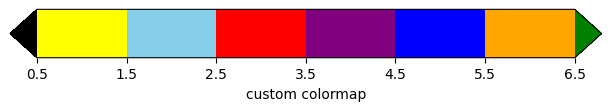

In [ ]:
# make custom colormap
import matplotlib.cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax, orientation='horizontal',
    extend='both',
    spacing='proportional',
    label='custom colormap',
)

In [120]:
import nibabel as nib

class NIfTIDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None, prefix="", postfix=""):

        self.inputs_paths = []
        self.targets_paths = []

        for path in os.listdir(image_dir):
            if path.startswith(prefix) and path.endswith(f"image.nii{postfix}"):
                self.inputs_paths.append(os.path.join(image_dir, path))
                
        for path in os.listdir(label_dir):
            if path.startswith(prefix) and path.endswith(f"label.nii{postfix}"):
                self.targets_paths.append(os.path.join(label_dir, path))

        if len(self.inputs_paths) != len(self.targets_paths):
            raise ValueError(f"Inputs and targets have different lengths: {len(self.inputs_paths)} vs {len(self.targets_paths)}")
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.inputs_paths)
    
    def __getitem__(self, idx):
        image_path = self.inputs_paths[idx]
        label_path = self.targets_paths[idx]

        image = nib.load(image_path)
        label = nib.load(label_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

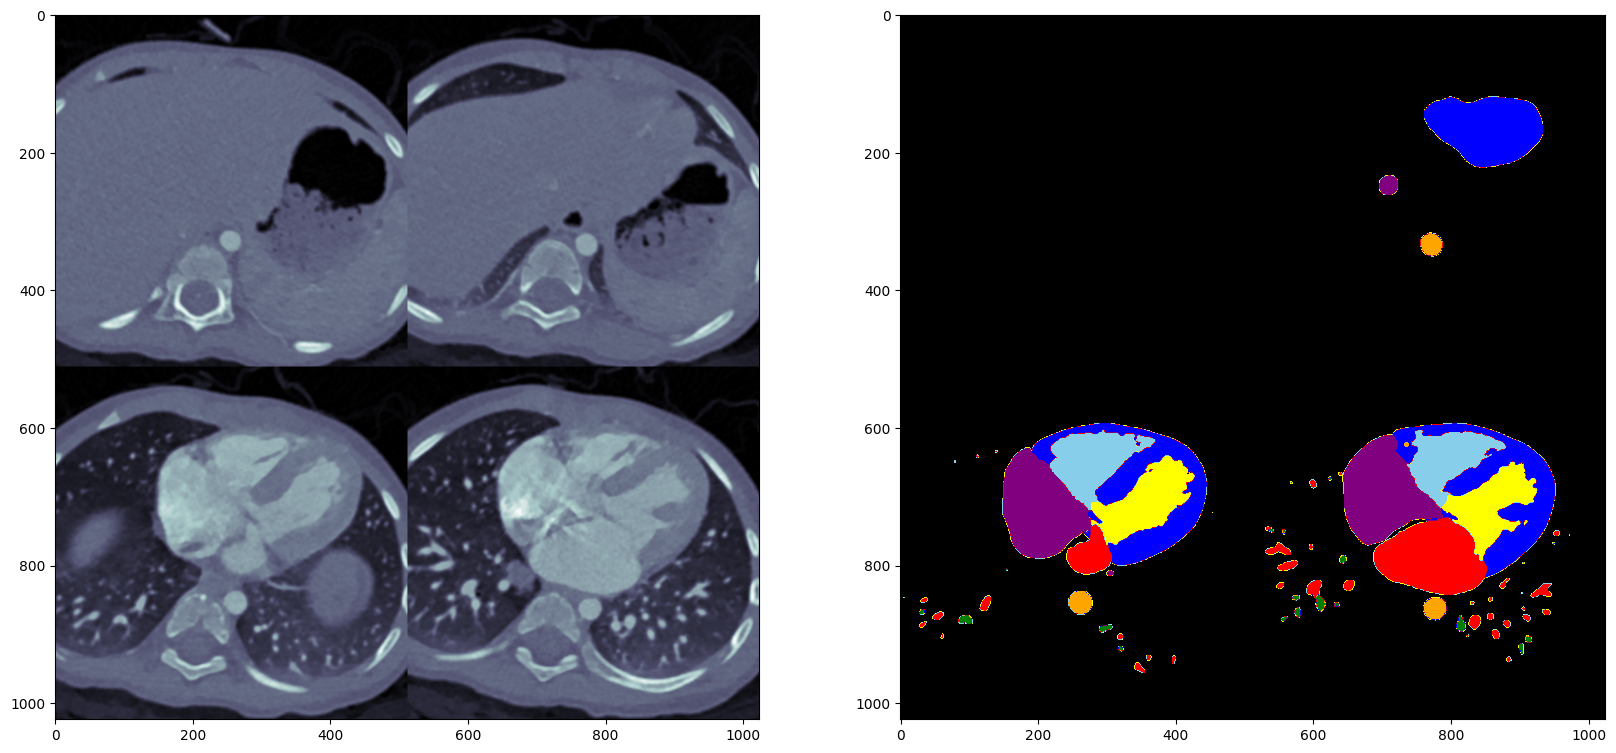

In [145]:
import skimage
import matplotlib.pyplot as plt

nifti_dataset = NIfTIDataset(
    image_dir=DATA_PATH,
    label_dir=DATA_PATH,
    transform=None,
    target_transform=None,
    postfix=".gz"
)

image, label = nifti_dataset[0]

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(skimage.util.montage(image.get_fdata().T[:100:25]), cmap="bone")
ax[1].imshow(skimage.util.montage(label.get_fdata().T[:100:25]), cmap=cmap, norm=norm)

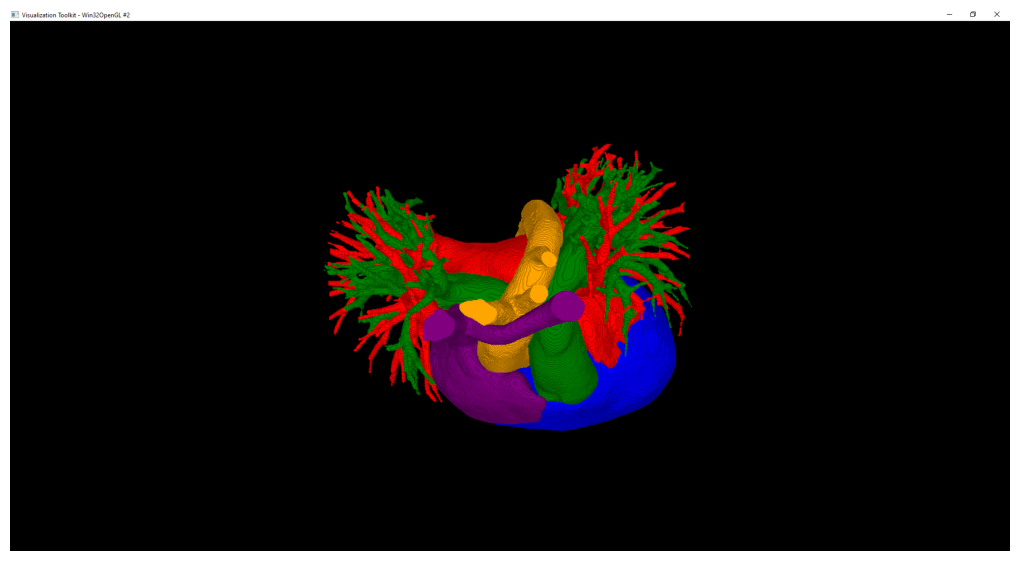

In [ ]:
import visualization

# visualization.vtk_visualize_3d_numpy_array(label.get_fdata(), label_color_map)
image = plt.imread("./figures/vtk-miccai19.png")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax.imshow(image)

## 02. Data Preprocessing

In [ ]:
from tqdm import tqdm
import scipy.ndimage
import numpy as np

def nii_to_npy_preprocessing(image_dir, label_dir, prefix="", postfix=""):

    for path in tqdm(os.listdir(image_dir)):
        if path.startswith(prefix) and path.endswith(f"image.nii{postfix}"):
            image : nib.Nifti1Image = nib.load(os.path.join(image_dir, path))
            print(image.shape, end=" ")
            image = image.get_fdata()
            scales = [256.0/image.shape[0], 256.0/image.shape[1], 128.0/image.shape[2]]
            print(scales)
            scaled_image = scipy.ndimage.zoom(image, scales, mode="reflect")
            print(scaled_image.shape)
            np.save(os.path.join(image_dir, path + ".256256128.npy"), scaled_image)
        
    for path in tqdm(os.listdir(label_dir)):
        if path.startswith(prefix) and path.endswith(f"label.nii{postfix}"):
            label : nib.Nifti1Image = nib.load(os.path.join(label_dir, path))
            label = label.get_fdata()
            scales = [256.0/label.shape[0], 256.0/label.shape[1], 128.0/label.shape[2]]
            scaled_label = scipy.ndimage.zoom(label, scales, order=0, mode="reflect")
            np.save(os.path.join(label_dir, path + ".256256128.npy"), scaled_label)

# nii_to_npy_preprocessing(DATA_PATH, DATA_PATH, postfix=".gz")

100%|██████████| 204/204 [00:49<00:00,  4.11it/s]


In [185]:
import numpy as np
from torchvision import transforms
import dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None, prefix="", postfix=""):

        self.inputs_paths = []
        self.targets_paths = []

        for path in os.listdir(image_dir):
            if path.startswith(prefix) and path.endswith(f"image.nii{postfix}"):
                self.inputs_paths.append(os.path.join(image_dir, path))
                
        for path in os.listdir(label_dir):
            if path.startswith(prefix) and path.endswith(f"label.nii{postfix}"):
                self.targets_paths.append(os.path.join(label_dir, path))

        if len(self.inputs_paths) != len(self.targets_paths):
            raise ValueError(f"Inputs and targets have different lengths: {len(self.inputs_paths)} vs {len(self.targets_paths)}")
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.inputs_paths)
    
    def __getitem__(self, idx):
        image_path = self.inputs_paths[idx]
        label_path = self.targets_paths[idx]

        image = np.load(image_path)
        label = np.load(label_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

class ImagePreprocessing(object):
    def __call__(self, image : np.ndarray):
        # image = (image - image.min()) / (image.max() - image.min())
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image).type(torch.FloatTensor)
        return image

class SortLabels(object):
    def __init__(self, sorted_labels : list):
        self.sorted_labels = sorted_labels

    def __call__(self, label : np.ndarray):
        label = label[self.sorted_labels, :, :, :]
        return label

test_dataset = Dataset(
    image_dir=DATA_PATH,
    label_dir=DATA_PATH,
    transform=transforms.Compose([transforms.ToTensor(),
        dataset.ImagePreprocessing()]),
    target_transform=transforms.Compose(transforms=[transforms.ToTensor(),
        dataset.LabelPreprocessing(label_values),
                                                    SortLabels(sorted_labels=[0, 3, 5, 2, 4, 1, 6, 7])]),
    postfix=".gz.256256128.npy"
)

In [186]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset,
                                batch_size=1)

## 03. Download model & evaluate

In [187]:
import mmwhs_model
hparams = {
        'n_channels':1,
        'n_classes':8,
    }
model = mmwhs_model.Unet3D(None, test_dataloader, hparams)
checkpoint_file = torch.load('checkpoints/mmwhs_v1.ckpt', weights_only=False)
model.load_state_dict(checkpoint_file['state_dict'])
model = model.to(device)

{'n_channels': 1, 'n_classes': 8}


In [ ]:
from tabulate import tabulate
import dataset, mmwhs_metrics
label_names = [value[1] for value in label_color_map.values()]
data = [ ["", *label_names, "mean"] ]
with torch.no_grad():
    model.eval()
    import itertools
    for i, (inputs, targets) in enumerate(itertools.islice(test_dataloader, 3)):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outputs = dataset.label_postprocessing(outputs)
        targets = targets.int().squeeze(0).to("cpu")
        metrics = mmwhs_metrics.Metrics(outputs, targets)
        
        data.append([f"{i}"])
        iou = metrics.IoU().numpy()
        mean_iou = metrics.meanIoU().numpy()
        data.append(["IoU", *iou, mean_iou])
        dice = metrics.Dice().numpy()
        mean_dice = metrics.meanDice().numpy()
        data.append(["Dice", *dice, mean_dice])

print(tabulate(data, headers="firstrow", tablefmt="fancy_grid", numalign="center"))

╒══════╤══════════════╤══════════════════╤═══════════════════╤═══════════════╤════════════════╤═════════════╤═══════════╤════════════════════════╤═══════════╕
│      │  background  │  left ventricle  │  right ventricle  │  left atrium  │  right atrium  │  myocarium  │   aorta   │  the pulmonary artery  │   mean    │
╞══════╪══════════════╪══════════════════╪═══════════════════╪═══════════════╪════════════════╪═════════════╪═══════════╪════════════════════════╪═══════════╡
│ 0    │              │                  │                   │               │                │             │           │                        │           │
├──────┼──────────────┼──────────────────┼───────────────────┼───────────────┼────────────────┼─────────────┼───────────┼────────────────────────┼───────────┤
│ IoU  │   0.419829   │        0         │     0.0273163     │   0.0609251   │       0        │      0      │ 0.0175105 │           0            │ 0.0656976 │
├──────┼──────────────┼──────────────────┼────

## 04. Result Visualization

torch.Size([1, 1, 128, 256, 256]) torch.Size([1, 8, 128, 256, 256]) torch.Size([1, 8, 128, 256, 256])


Text(0.5, 1.0, 'Target')

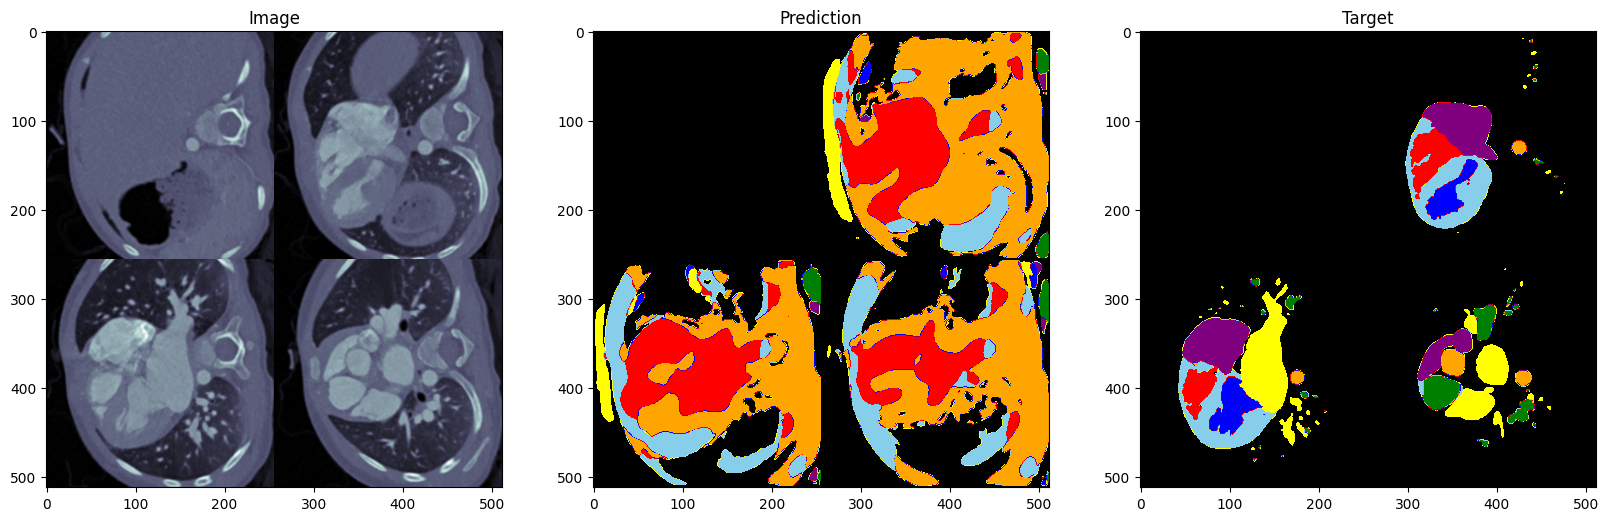

In [190]:
inputs, targets = next(iter(test_dataloader))
with torch.no_grad():
    inputs = inputs.to(device)
    model.eval()
    outputs : torch.Tensor= model(inputs)

print(inputs.shape, targets.shape, outputs.shape)

r = torch.softmax(outputs, dim=1).argmax(dim=1).squeeze(0).cpu()
targets = torch.argmax(targets, dim=1).squeeze(0).cpu()
inputs = inputs.squeeze().cpu().numpy()

# fig, ax = plt.subplots(1, 3, figsize=(20, 20))
# ax[0].imshow(skimage.util.montage(inputs.T[:100:25]), cmap="bone")
# ax[0].set_title("Image")
# ax[1].imshow(skimage.util.montage(r.T[:100:25]), cmap=cmap, norm=norm)
# ax[1].set_title("Prediction")
# ax[2].imshow(skimage.util.montage(targets.T[:100:25]), cmap=cmap, norm=norm)
# ax[2].set_title("Target")
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(skimage.util.montage(inputs[:100:25]), cmap="bone")
ax[0].set_title("Image")
ax[1].imshow(skimage.util.montage(r[:100:25]), cmap=cmap, norm=norm)
ax[1].set_title("Prediction")
ax[2].imshow(skimage.util.montage(targets[:100:25]), cmap=cmap, norm=norm)
ax[2].set_title("Target")

In [191]:
visualization.vtk_visualize_3d_numpy_array(r.numpy(), label_color_map)